In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import torch.optim as optim

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import zipfile

# Define the path to the zip file and the destination folder
zip_file_path = '/content/drive/My Drive/braindata/1512427.zip'
destination_folder = '/content/drive/My Drive/braindata/'

# Unzip the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


In [9]:
import zipfile

# Define the paths to the zip files and destination folders for each subset
subsets = [
    ('/content/drive/My Drive/braindata/brainTumorDataPublic_1-766.zip', '/content/drive/My Drive/braindata/'),
    ('/content/drive/My Drive/braindata/brainTumorDataPublic_767-1532.zip', '/content/drive/My Drive/braindata/'),
    ('/content/drive/My Drive/braindata/brainTumorDataPublic_1533-2298.zip', '/content/drive/My Drive/braindata/'),
    ('/content/drive/My Drive/braindata/brainTumorDataPublic_2299-3064.zip', '/content/drive/My Drive/braindata/')
]

# Unzip each data subset
for zip_file, destination_folder in subsets:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)


In [11]:
!pip install h5py



In [16]:
import h5py

# Define the path to the cvind.mat file
cvind_file_path = '/content/drive/My Drive/braindata/cvind.mat'

# Load the cvind.mat file using h5py
with h5py.File(cvind_file_path, 'r') as mat_file:
    # Access the dataset within the file
    dataset = mat_file['cvind']

    # Retrieve the data as a NumPy array
    data = dataset[()]

    # Display the shape of the data (if it's a 1D array)
    print("Data shape:", data.shape)

    # Access the data for further analysis or processing
    print("Data:", data)


Data shape: (1, 3064)
Data: [[5. 5. 5. ... 4. 2. 1.]]


In [27]:
import h5py
import numpy as np
import cv2
import torchvision.transforms as transforms
from PIL import Image

# Define the path to the directory containing the .mat files
mat_files_dir = '/content/drive/My Drive/braindata/'

# Initialize empty lists to store your feature data (X) and target labels (y)
X = []
y = []

# Define the desired shape for the image data
desired_shape = (255, 255)

# Define the data transformation
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert the tensor to a PIL Image
    transforms.Resize(desired_shape),  # Resize the image
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values for a single channel
])

# Iterate through the .mat files and load their contents
for file_number in range(1, 3065):
    file_path = f'{mat_files_dir}{file_number}.mat'

    # Load data from the current .mat file using h5py
    with h5py.File(file_path, 'r') as mat_file:
        # Extract and append image data (features) and tumor type (labels) to the lists
        # "cjdata.image" contains the image data, and "cjdata.label" contains the tumor type
        image_data = mat_file['cjdata']['image'][()]  # Adjust the indexing as needed

        # Convert the image data to a float tensor
        image_data = torch.tensor(image_data, dtype=torch.float32)

        # Apply the specified transformation
        image_data = transform(image_data)

        tumor_type = mat_file['cjdata']['label'][()][0, 0]  # Adjust the indexing as needed

    # Append the transformed image data and tumor type to the respective lists
    X.append(image_data)
    y.append(tumor_type)

# Convert the lists to NumPy arrays
X = torch.stack(X)
y = np.array(y)

# Now, we have the transformed grayscale image data (X) and tumor type labels (y) loaded and ready for further processing.
# The goal is to build a model that classifies brain tumor images into one of the three categories based on the transformed image data.


In [28]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# X_train and y_train will contain 80% of the data for training
# X_test and y_test will contain 20% of the data for testing


In [31]:
# Flatten the 4D data to 2D
X_train_flat = X_train.view(X_train.shape[0], -1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=100)

# Train the classifier on the flattened training data
rf_classifier.fit(X_train_flat, y_train)

# Reshape the test data in the same way
X_test_flat = X_test.view(X_test.shape[0], -1)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9363784665579119


In [32]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate the log loss
# Note: RandomForestClassifier doesn't directly provide probabilities, so you might need to use a different classifier for log loss calculation.
# If you have probabilities, you can use log_loss(y_test, probabilities), where 'probabilities' are the predicted probabilities for each class.
#Random Forest is an ensemble learning algorithm composed of decision trees that make binary decisions at each node,
#resulting in discrete class predictions rather than continuous probabilities.
# Log loss relies on continuous probability predictions to measure how confident a model is in its predictions, which is inherently at odds with the nature of Random Forest.
#In essence, Random Forest doesn't produce the probability estimates necessary for log loss calculation.
print("Log Loss: Not applicable for RandomForestClassifier")


Confusion Matrix:
[[146   1   0]
 [ 32 235   3]
 [  0   3 193]]
F1 Score: 0.9370085209854198
Log Loss: Not applicable for RandomForestClassifier


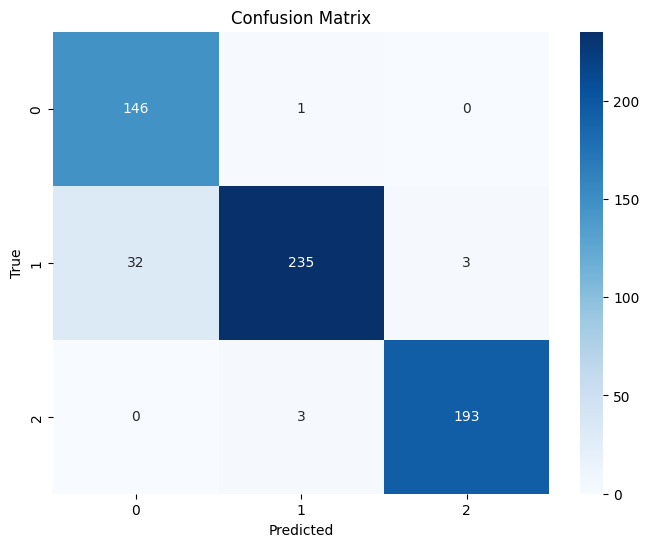

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have 'y_test' (true labels) and 'y_pred' (predicted labels) defined

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
